## Imports

In [2]:
%pip install leia-br
from LeIA import SentimentIntensityAnalyzer
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter
from wordcloud import WordCloud
from pandas import plotting
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk

In [3]:
seed = 42

## Carregando o dataset

In [4]:
def load_data(file_path):
    return pd.read_parquet(file_path)

products_file = 'data/olist_products_dataset.parquet'
orders_file = 'data/olist_orders_dataset.parquet'
order_items_file = 'data/olist_order_items_dataset.parquet'
customers_file = 'data/olist_customers_dataset.parquet'
geolocation_file = 'data/olist_geolocation_dataset.parquet'
payments_file = 'data/olist_order_payments_dataset.parquet'
reviews_file = 'data/olist_order_reviews_dataset.parquet'
sellers_file = 'data/olist_sellers_dataset.parquet'
category_file = 'data/product_category_name_translation.parquet'

products_df = load_data(products_file)
orders_df = load_data(orders_file)
order_items_df = load_data(order_items_file)
customers_df = load_data(customers_file)
geolocation_df = load_data(geolocation_file)
payments_df = load_data(payments_file)
reviews_df = load_data(reviews_file)
sellers_df = load_data(sellers_file)
category_df = load_data(category_file)

# Merge dos dataframes
all_data = orders_df.merge(reviews_df, on='order_id')\
                   .merge(payments_df, on='order_id')\
                   .merge(customers_df, on='customer_id')\
                   .merge(order_items_df, on='order_id')\
                   .merge(products_df, on='product_id')\
                   .merge(sellers_df, on='seller_id')
# Remover as duplicatas
all_data = all_data.drop_duplicates()

# Remover os comentários vazios
all_data = all_data.dropna(subset=['review_comment_message'])

In [ ]:
all_data.shape

## Resumo do Dataframe -> Pré-Processamento

###### Usamos a função `df_summary` para dar uma olhada nos nossos dados de forma geral. Ela é mais informativa e legível do que a função `DataFrame.info()` fornecida pelo Pandas. Também usaremos isso para checar nossos dados após o pré-processamento.

In [5]:
def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column','dtypes']]
    summary['# Missing'] = df.isnull().sum().values
    summary['# Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values

    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)

    return summary

Dataset Shape: (49679, 39)


,Column,dtypes,# Missing,# Unique,Example,Entropy
0,order_id,object,0,40311,e481f51cbdc54678b7cc49136f2d6af7,15.14
1,customer_id,object,0,40311,9ef432eb6251297304e76186b10a928d,15.14
2,order_status,object,0,6,delivered,0.26
3,order_purchase_timestamp,object,0,40188,2017-10-02 10:56:33,15.14
4,order_approved_at,object,8,38748,2017-10-02 11:07:15,15.07
5,order_delivered_carrier_date,object,823,36015,2017-10-04 19:55:00,14.92
6,order_delivered_customer_date,object,1585,38810,2017-10-10 21:25:13,15.09
7,order_estimated_delivery_date,object,0,437,2017-10-18 00:00:00,8.48
8,review_id,object,0,40179,a54f0611adc9ed256b57ede6b6eb5114,15.14
9,review_score,int64,0,5,4,1.95


### Convertendo tipos de dados e corrigindo nomes imppróprios pras colunas

In [6]:
datetime_columns = ['order_purchase_timestamp', 'order_approved_at',
                    'order_delivered_carrier_date', 'order_delivered_customer_date',
                    'order_estimated_delivery_date',
                    'review_creation_date', 'review_answer_timestamp',
                    'shipping_limit_date']
all_data[datetime_columns] = all_data[datetime_columns].apply(pd.to_datetime)

In [7]:
all_data = all_data.rename(columns={'product_name_lenght': 'product_name_length',
                                   'product_description_lenght': 'product_description_length'
                                  })

In [8]:
df_summary(all_data)

Dataset Shape: (49679, 39)


,Column,dtypes,# Missing,# Unique,Example,Entropy
0,order_id,object,0,40311,e481f51cbdc54678b7cc49136f2d6af7,15.14
1,customer_id,object,0,40311,9ef432eb6251297304e76186b10a928d,15.14
2,order_status,object,0,6,delivered,0.26
3,order_purchase_timestamp,datetime64[ns],0,40188,2017-10-02 10:56:33,15.14
4,order_approved_at,datetime64[ns],8,38748,2017-10-02 11:07:15,15.07
5,order_delivered_carrier_date,datetime64[ns],823,36015,2017-10-04 19:55:00,14.92
6,order_delivered_customer_date,datetime64[ns],1585,38810,2017-10-10 21:25:13,15.09
7,order_estimated_delivery_date,datetime64[ns],0,437,2017-10-18 00:00:00,8.48
8,review_id,object,0,40179,a54f0611adc9ed256b57ede6b6eb5114,15.14
9,review_score,int64,0,5,4,1.95


In [ ]:
analyzer = SentimentIntensityAnalyzer()

compound_scores = []
neg_scores = []
pos_scores = []
neu_scores = []

for review in all_data['review_comment_message']:
  s = analyzer.polarity_scores(review)
  compound_scores.append(s['compound'])
  neg_scores.append(s['neg'])
  pos_scores.append(s['pos'])
  neu_scores.append(s['neu'])

all_data['comp_score'] = compound_scores
all_data['neg'] = neg_scores
all_data['pos'] = pos_scores
all_data['neu'] = neu_scores

In [ ]:
conditions = [
    (all_data['comp_score'] > 0.0),
    (all_data['comp_score'] < 0.0),
    (all_data['comp_score'] == 0.0)
]

choices = [1, -1, 0]

all_data['polarity'] = np.select(conditions, choices)

In [ ]:
all_data[['review_comment_message', 'polarity','comp_score', 'neg', 'pos', 'neu']].head(50)

# EDA para Classificação

## Correlações

##### Primeiro de tudo, encontramos correlação em nosso conjunto de dados. Essa etapa é importante porque pode nos ajudar a identificar relacionamentos entre diferentes variáveis. Variáveis correlacionadas podem nos ajudar a raciocinar sobre possíveis causas e efeitos.

##### Os dados contêm colunas de diferentes tipos. Para a análise de correlação, focamos nas colunas numéricas. Então, precisamos primeiro filtrar as colunas numéricas.

In [10]:
numeric_columns = ['review_score', 'payment_sequential', 'payment_installments',
                   'payment_value', 'price', 'freight_value', 'product_name_length',
                   'product_description_length', 'product_photos_qty', 'product_weight_g',
                   'product_length_cm', 'product_height_cm', 'product_width_cm']
numeric_df = all_data[numeric_columns]
corr = numeric_df.corr()

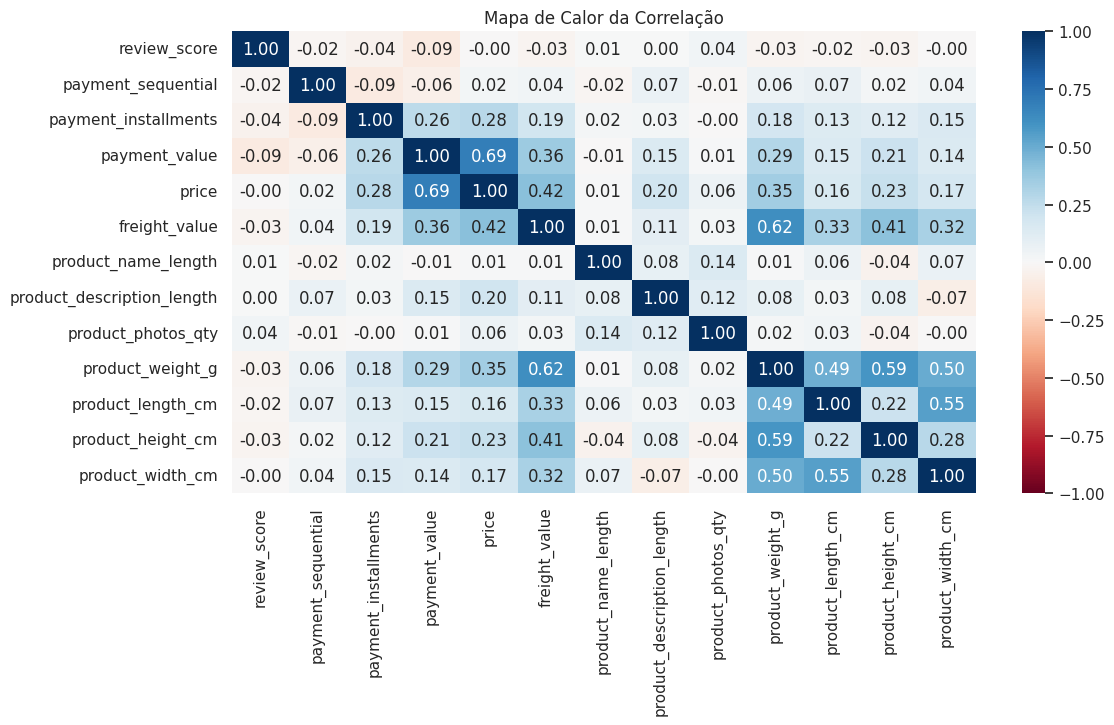

In [11]:
plt.figure(figsize=(12, 6))
sns.heatmap(corr, cmap='RdBu', norm=plt.Normalize(-1,1), annot=True, fmt='.2f')
plt.title("Mapa de Calor da Correlação")
plt.show()

## Status de Entrega

##### A partir das informações no status do pedido, podemos saber em qual etapa os clientes estão. Além de "entregue", que é a etapa final nesse sistema de status de pedidos, existem etapas como "enviado", "cancelado", etc. Essas informações sobre o status do pedido podem ser significativas e se tornar um dos fatores que influenciam as notas dos avaliadores. Para status como "cancelado" ou "indisponível", isso pode prejudicar a experiência do usuário e, consequentemente, diminuir as avaliações. Além disso, quando o status mostra "enviado", "em processamento" ou qualquer outra etapa de pré-processamento, podem ocorrer alguns erros que impedem o andamento do pedido e o impede de ser marcado como "entregue". Portanto, analisamos as notas médias de avaliação para esses pedidos não entregues abaixo.

In [14]:
shipped_review_mean = all_data[all_data['order_status'] == 'shipped']['review_score'].mean(axis=0)
canceled_review_mean = all_data[all_data['order_status'] == 'canceled']['review_score'].mean(axis=0)
invoiced_review_mean = all_data[all_data['order_status'] == 'invoiced']['review_score'].mean(axis=0)
processing_review_mean = all_data[all_data['order_status'] == 'processing']['review_score'].mean(axis=0)
unavailable_review_mean = all_data[all_data['order_status'] == 'unavailable']['review_score'].mean(axis=0)
approved_review_mean = all_data[all_data['order_status'] == 'approved']['review_score'].mean(axis=0)

print(f'The mean review score for "shipped" order is {shipped_review_mean}')
print(f'The mean review score for "canceled" order is {canceled_review_mean}')
print(f'The mean review score for "invoiced" order is {invoiced_review_mean}')
print(f'The mean review score for "processing" order is {processing_review_mean}')
print(f'The mean review score for "unavailable" order is {unavailable_review_mean}')
print(f'The mean review score for "approved" order is {approved_review_mean}')

The mean review score for "shipped" order is 1.6746143057503506
The mean review score for "canceled" order is 1.4108108108108108
The mean review score for "invoiced" order is 1.38671875
The mean review score for "processing" order is 1.2768595041322315
The mean review score for "unavailable" order is 1.0
The mean review score for "approved" order is nan


<ipython-input-15-d2c9134bb9f1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  order_status_plot = sns.countplot(x='order_status', data=full_df[order_status_columns], ax=axes[0], palette=("Blues_d"))
<ipython-input-15-d2c9134bb9f1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  order_status_plot_med = sns.countplot(x='order_status', data=full_df[order_status_columns], ax=axes[1], palette=("Blues_d"))
<ipython-input-15-d2c9134bb9f1>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  order_status_plot_smaller = sns.countplot(x='order_status', data=full_df[order_status_columns

Text(0.5, 0.98, 'Ocorrência do Status de Entrega')

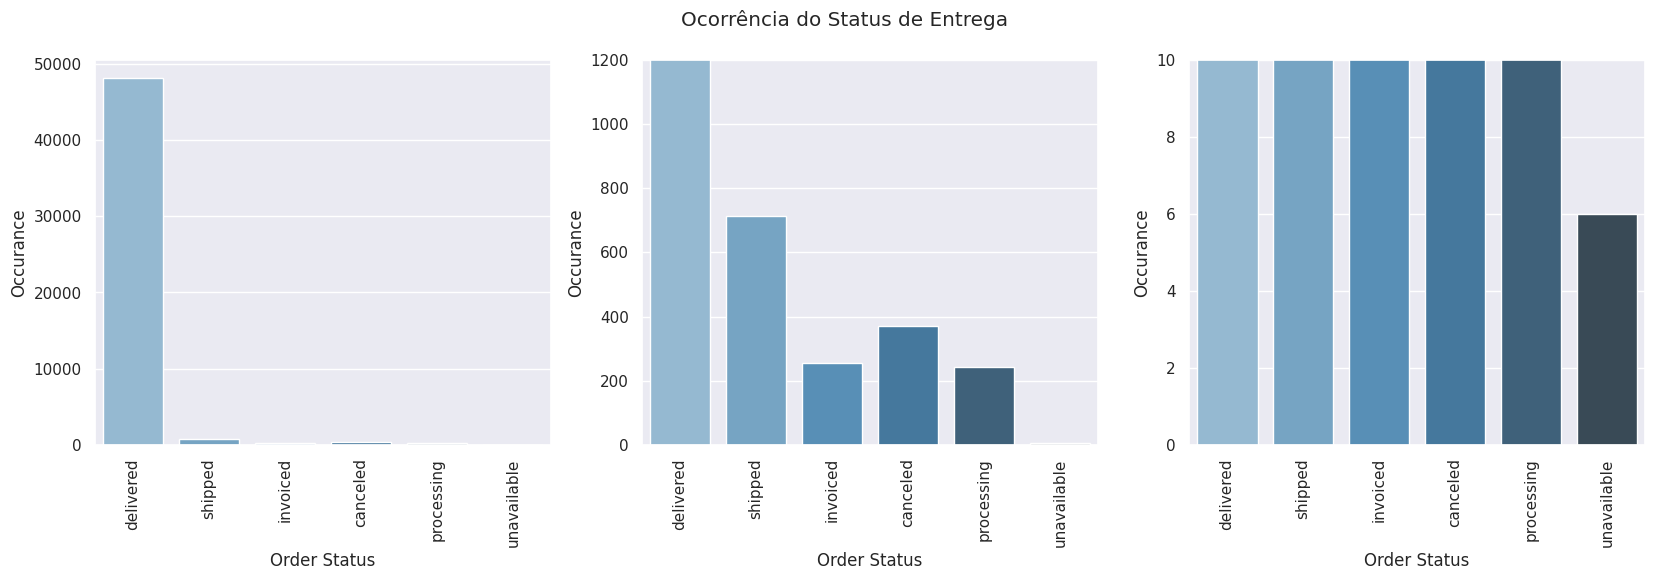

In [15]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(20,5))
order_status_columns = ['order_id', 'order_status']

order_status_plot = sns.countplot(x='order_status', data=full_df[order_status_columns], ax=axes[0], palette=("Blues_d"))
order_status_plot.set(xlabel = 'Order Status', ylabel='Occurance', ylim=(0, None))
order_status_plot.tick_params(axis='x', rotation=90)

order_status_plot_med = sns.countplot(x='order_status', data=full_df[order_status_columns], ax=axes[1], palette=("Blues_d"))
order_status_plot_med.set(xlabel='Order Status', ylabel='Occurance', ylim=(0, 1200))
order_status_plot_med.tick_params(axis='x', rotation=90)

order_status_plot_smaller = sns.countplot(x='order_status', data=full_df[order_status_columns], ax=axes[2], palette=("Blues_d"))
order_status_plot_smaller.set(xlabel='Order Status', ylabel='Occurance', ylim=(0, 10))
order_status_plot_smaller.tick_params(axis='x', rotation=90)

fig.suptitle('Ocorrência do Status de Entrega')

## NLP nas `review_comment_message`'s

##### No dataframe, podemos observar muitos dados de texto que podem ser valiosos para análise. Vamos dividir o conteúdo da coluna em uma lista de palavras e usaremos a biblioteca nltk para facilitar o processamento do texto.

##### Limpando a coluna `review_comment_message` para substituir valores vazios ou inválidos, como NaN, para análise.

In [17]:
all_data[['review_comment_message']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 49679 entries, 0 to 117314
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_comment_message  49679 non-null  object
dtypes: object(1)
memory usage: 1.8+ MB


##### Para poder analisar as mensagens dos comentários que recebemos, precisamos remover os valores nulos primeiro:

In [18]:
review_comment_message_dropna = all_data['review_comment_message'].dropna()
review_comment_message_dropna

,review_comment_message
0,"Não testei o produto ainda, mas ele veio corre..."
1,"Não testei o produto ainda, mas ele veio corre..."
2,"Não testei o produto ainda, mas ele veio corre..."
3,Deveriam embalar melhor o produto. A caixa vei...
4,"Só achei ela pequena pra seis xícaras ,mais é ..."
...,...
117308,"Ainda não recebi meu produto, espero uma respo..."
117309,"Ainda não recebi meu produto, espero uma respo..."
117310,Ainda aguardo o produto. Após recebimento ou p...
117312,Tudo certo!


##### Com os dados limpos, podemos começar a usar a biblioteca nltk e avaliar o conteúdo da mensagem

In [19]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
# Importando a biblioteca 'stopwords'
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_pt = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Usando a função `tokenize_content` para tokenizar as frases da avaliação para uma análise posterior

In [21]:
# Tokenizando uma dada string
def tokenize_content(content):
  words = [word.lower() for word in nltk.word_tokenize(content) if word.isalpha()]
  words = [word for word in words if word not in stopwords_pt]
  return words

In [22]:
reviews = review_comment_message_dropna.tolist()
top_tokens_list = []

# Create top_tokens_list for all words in reviews
for review in reviews:
  token_words = tokenize_content(review)
  top_tokens_list.append(token_words)

top_tokens = [item for sublist in top_tokens_list for item in sublist]

##### Computando a lista `top_most_common` para mostrar as palavras que aparecem com mais frequência nos comentários das avaliações

In [23]:
cnt = Counter()

# Contando as occurances das palavras
for word in top_tokens:
  cnt[word] += 1

top_most_common = sorted(cnt.items(), key=lambda item: -item[1])[:100]

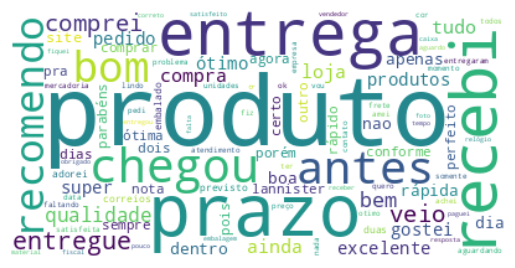

In [24]:
span_freq_dict = {}

# Creat top most common words dict with frequencies
for i in top_most_common:
  # Ignore the word if it is in stopwords in english
  span_freq_dict[i[0]] = i[1]

wc = WordCloud(background_color='white')
wc.generate_from_frequencies(span_freq_dict)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Feature Engineering

##### Resolvendo a desarmonia do `review_score`

##### A partir dos dados de `review_score` e do gráfico abaixo, podemos notar que há um desequilíbrio entre os scores, onde o score 5 tem muito mais contagens em comparação com os outros scores. Para lidar com isso, tentamos combinar alguns dos scores e tornamos o `review_score` categórico, o que pode diminuir o desequilíbrio.

##### Criando uma coluna chamada `review_score_factor`, que pode conter 3 valores (0, 1, 2) que representam, respectivamente, baixo (scores 1, 2), médio (scores 3, 4) e alto (score 5) na seguinte forma:

In [26]:
print("review_score == 5: %d" % len(all_data[all_data['review_score']==5]))
print("review_score == 4: %d" % len(all_data[all_data['review_score']==4]))
print("review_score == 3: %d" % len(all_data[all_data['review_score']==3]))
print("review_score == 2: %d" % len(all_data[all_data['review_score']==2]))
print("review_score == 1: %d" % len(all_data[all_data['review_score']==1]))
score_list = [len(all_data[all_data['review_score']==1]),
              len(all_data[all_data['review_score']==2]),
              len(all_data[all_data['review_score']==3]),
              len(all_data[all_data['review_score']==4]),
              len(all_data[all_data['review_score']==5])]

review_score == 5: 23645
review_score == 4: 7086
review_score == 3: 4505
review_score == 2: 2882
review_score == 1: 11561


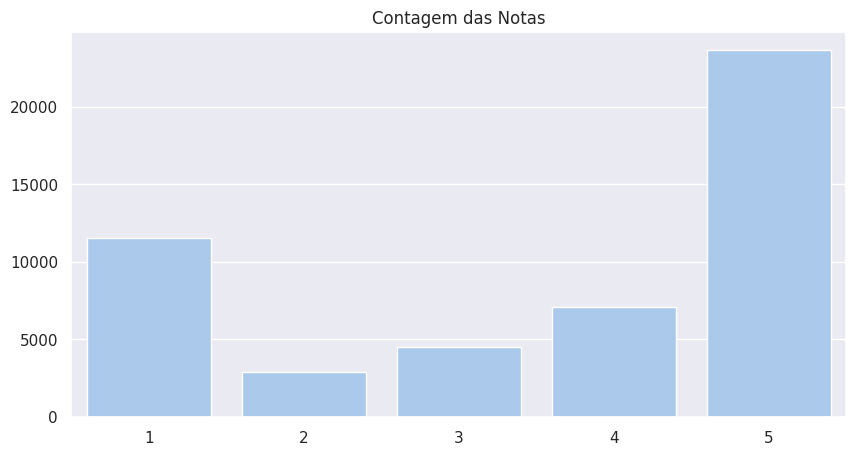

In [27]:
plt.figure(figsize=(10,5))
chart = sns.barplot(x=[1,2,3,4,5], y=score_list)
chart.set(title="Contagem das Notas")
plt.show()

In [28]:
# Clonando `all_data` pro `feature_df` pra ser usando nos modelos futuros
feature_df = all_data

# Amontoando os `review_score`s
feature_df.loc[feature_df['review_score'] == 5, "review_score_factor"] = 2
feature_df.loc[feature_df['review_score'] <= 4, "review_score_factor"] = 1
feature_df.loc[feature_df['review_score'] <= 2, "review_score_factor"] = 0

In [29]:
feature_df['review_score_factor']

,review_score_factor
0,1.0
1,1.0
2,1.0
3,1.0
4,2.0
...,...
117308,0.0
117309,0.0
117310,0.0
117312,1.0


### Mudando `price` e `freight_value` para valor categórico, pra facilitar a leitura da máquina

In [30]:
price_median = feature_df['price'].median();
feature_df.loc[feature_df['price'] >= price_median, "price_factor"] = 1
feature_df.loc[feature_df['price'] < price_median, "price_factor"] = 0

freight_value_median = feature_df['freight_value'].median();
feature_df.loc[feature_df['freight_value'] >= freight_value_median, "freight_value_factor"] = 1
feature_df.loc[feature_df['freight_value'] < freight_value_median, "freight_value_factor"] = 0

### Determinar se o pacote foi `delivered` ou não

In [32]:
feature_df.loc[feature_df['order_status'] == 'delivered', "if_delivered"] = 1
feature_df.loc[feature_df['order_status'] != 'delivered', "if_delivered"] = 0

### Diferenças entre data de entrega estimada e atual

In [33]:
# Check how many rows in non_delivered records don't have data in `order_delivered_customer_date`
non_delivered = feature_df[feature_df['if_delivered'] == 0]
nan_delivered_customer_count = non_delivered[non_delivered['order_delivered_customer_date'].isnull()]['order_id'].count()
print(f'There are {nan_delivered_customer_count} rows isnull in order_delivered_customer_date column for all non_delivered rows')

There are 1580 rows isnull in order_delivered_customer_date column for all non_delivered rows


In [34]:
feature_df.loc[feature_df['order_delivered_customer_date'].isnull(), "order_delivered_customer_date"] = feature_df['order_estimated_delivery_date']
# Mantendo a diferença em dias na coluna
feature_df['actual_est_delivery_diff'] = (feature_df['order_estimated_delivery_date'] - feature_df['order_delivered_customer_date']).dt.days

### Finalmente, contabilizando quantos dias demoraram pra receber o pacote

In [36]:
feature_df['delivery_duration'] = (feature_df['order_delivered_customer_date'] - feature_df['order_purchase_timestamp']).dt.days

##### Definindo o `product_photos_qty` e `product_description_length` como 0 por padrão se o registro original for nulo aqui.

##### Removemos a linha se ela não tiver um peso.

In [37]:
feature_df.loc[feature_df['product_photos_qty'].isnull(), "product_photos_qty"] = 0
feature_df.loc[feature_df['product_description_length'].isnull(), "product_description_length"] = 0
feature_df = feature_df.dropna(subset=['product_weight_g'])

##### Ao listar o nome da categoria do produto, percebemos que algumas linhas no full_df não têm nenhuma informação sobre nome do produto, categoria do produto, descrição do produto e fotos do produto. Essas linhas podem ser erros ou dados de teste que não fazem sentido. Portanto, antes de fazermos a codificação one-hot da categoria do produto, limpamos o dataframe removendo as linhas que não têm nome do produto.

In [38]:
feature_df = feature_df.dropna(subset=['product_name_length'])

In [ ]:
# Calculate the difference between actual and estimated delivery time
feature_df['delivery_time_diff'] = (feature_df['order_delivered_customer_date'] - feature_df['order_estimated_delivery_date']).dt.days

# Create the 'delivery' column based on delivery time difference
feature_df['delivery'] = feature_df['delivery_time_diff'].apply(lambda x:
    1 if x < 0
    else 1 if x == 0
    else 0
)

In [ ]:
# prompt: Levando em conta as informações das colunas 'review_comment_message', 'comp_score', 'review_score', 'review_score_factor' e 'delivery', você poderia demonstra a satisfação dos clientes, criando uma nova coluna chamada 'satisfaction' que indica se o cliente ficou satisfeito ou não, levando em conta todas as outras colunas (notas acima de 4 e 5 geralmente implicam que o cliente ficou satisfeit

def determine_satisfaction(row):
  if row['review_score_factor'] == 2:  # High review score
    return 1
  elif row['review_score_factor'] == 1:  # Medium review score
    if row['comp_score'] > 0:  # Positive sentiment
      return 1
    elif row['delivery'] == 1:  # Early delivery might compensate
      return 1
    else:
      return 0
  else:  # Low review score
    return 0

feature_df['satisfaction'] = feature_df.apply(determine_satisfaction, axis=1)

In [41]:
feature_df[['review_comment_message','comp_score', 'review_score', 'review_score_factor']].sort_values(by='comp_score', ascending=False)

,review_comment_message,comp_score,review_score,review_score_factor
25045,"Produtos lindos super da hora, chegaram em men...",0.9136,5,2.0
24954,"Produtos lindos super da hora, chegaram em men...",0.9136,5,2.0
82546,Adoreiii os capachos! super lindos <3 A entreg...,0.8748,5,2.0
82572,Adoreiii os capachos! super lindos <3 A entreg...,0.8748,5,2.0
117137,"Entrega super rápida, a mercadoria chegou muit...",0.8741,5,2.0
...,...,...,...,...
82586,MAS ACHO QUE TALVEZ NÃO FOI ENTRGUE NO PRAZO!!...,-0.8740,5,2.0
111302,Comprei 3 Whey Protein e 1 Hemo Rage no mesmo ...,-0.9039,1,0.0
82301,Comprei 3 Whey Protein e 1 Hemo Rage no mesmo ...,-0.9039,1,0.0
82303,Comprei 3 Whey Protein e 1 Hemo Rage no mesmo ...,-0.9039,1,0.0


In [7]:
feature_df['estimated_to_delivered_diff'] = (feature_df['order_estimated_delivery_date'] - feature_df['order_delivered_customer_date']).dt.days

feature_df['Nota'] = feature_df['review_score']

NameError: name 'feature_df' is not defined

In [ ]:
# Gráfico 1: Distribuição do tempo de envio em dias (sem outliers)
plt.figure(figsize=(20, 5), dpi=500)
test2 = feature_df['estimated_to_delivered_diff'][feature_df['estimated_to_delivered_diff'] > 60]
test = feature_df['estimated_to_delivered_diff'][feature_df['estimated_to_delivered_diff'] < 60]
sns.histplot(test, bins=15)
plt.title('Distribuição do Tempo de Envio em Dias (Sem Outliers)', fontsize=16, loc='left')
plt.xticks(fontsize=14)
plt.ylabel('')
plt.xlabel('Dias', fontsize=14)
plt.show()

# Gráfico 2: Gráfico de violinplot para a diferença de entrega estimada e real por nota
plt.figure(figsize=(20, 8))
sns.violinplot(data=feature_df, x='Nota', y='estimated_to_delivered_diff', palette='viridis')
plt.title('Diferença de Entregas Estimada - Real x Nota atribuída', fontsize=16, loc='left')
plt.xlabel('Nota', fontsize=16)
plt.ylabel('Diferença em Dias (Entregas Estimada - Data Real)', fontsize=16)
plt.show()